#   Learning of Lagrangian using a certified kernel-based method

In [12]:
using ForwardDiff
using Plots
using LinearAlgebra
#using DifferentialEquations
using NLsolve
using HaltonSequences
using BlockArrays
using SpecialFunctions
using Dates
using FileIO
using LaTeXStrings
using ProgressMeter

include("EL_utilities.jl");
include("L_learning_GP_utilities_ndim.jl");
include("VariationalMidpointRule.jl")

mNow() = string(Dates.format(now(), "yyyy-mm-dd_HH:MM:SS"));
println("Start: "*mNow())


Start: 2024-04-28_17:49:31


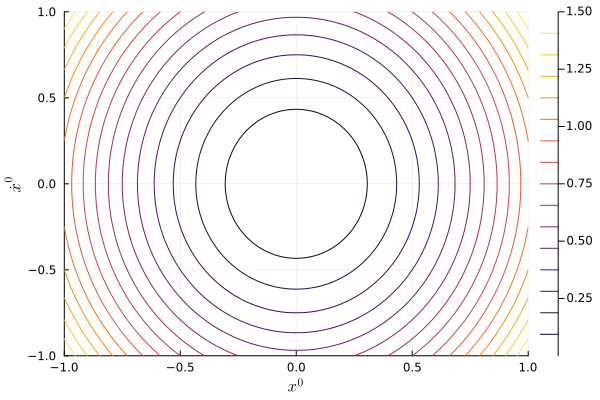

In [31]:
dimQ=2
dimTQ = 2*dimQ;

## coupled harmonic oscillators
coupling_constant = 0.1
L_ref(q,qdot) = 1/2*sum(qdot.^2) - sum(q.^2) + coupling_constant*prod(q)

## make available on jet variables
L_ref(qjet) = L_ref(qjet[1:dimQ],qjet[dimQ+1:end])

EL_ref,acc_ref,H_ref = EulerLagrange(L_ref);

delta = 1
xx = range(-delta, delta, length=80)
yy = range(-delta, delta, length=80)

x=(a->[a;0]).(xx)
x2=(a->[0;a]).(xx)
y=(a->[a;0]).(yy)
y2=(a->[0;a]).(yy)

pcontourHref0=contour(xx, yy, H_ref.(x',y),xlabel=L"x^0",ylabel=L"\dot{x}^0")
#plot!(size=(300,200)); savefig(pcontourHref0,"plots/ContourHref0_"*mNow()*".pdf")

In [32]:
u0_0 = [0.2, 0.1, 0., 0.]
tspan_0 = (0.0,100.0)
h_ref0 = 0.01
tt0 = tspan_0[1]:h_ref0:tspan_0[end]
steps0 = Int(tspan_0[end]/h_ref0)

sol_ref = ComputeTrajectory(LdMP(L_ref,h_ref0),u0_0[1:dimQ],u0_0[dimQ+1:end],steps0;ftol=1e-8);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


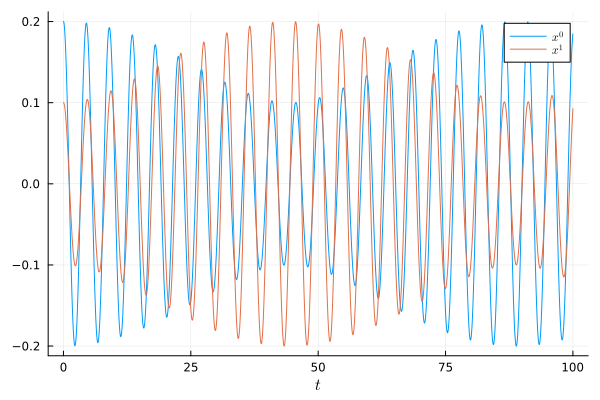

In [35]:
pSolRef0=plot(tt0,sol_ref', label=[L"x^0" L"x^1"],xlabel=L"t")
#plot!(size=(300,200)); savefig(pSolRef0,"plots/SolRef0_"*mNow()*".pdf")

#   Data generation

In [37]:
# samples and domain
NSamples = 300
domain_bnd = [1., 1.,1.,1.]
basept = zeros(4)

bnd_value = [1., 1., 1.] # normalisation of conj. momentum of L and value of L at base point

samples_per_unit = NSamples/prod(domain_bnd*2)
println("samples per unit: "*string(samples_per_unit))

data_TQ=HaltonPoint(2*dimQ,length=NSamples)
data_TQ=(a->domain_bnd.*(-ones(2*dimQ) .+ 2.0*a)).(data_TQ)

accl_ref(y::Vector) = acc_ref(y[1:dimQ],y[dimQ+1:end])
data_TQ2 = ((a,b) -> cat(dims=1,a,b)).(data_TQ,accl_ref.(data_TQ));

Data=hcat(data_TQ2...);

#predicted size of linear problem in training / predictions
size_theta = dimQ*(NSamples+1)+1
println("predicted size of linear problem "*string(size_theta)*"x"*string(size_theta))

samples per unit: 18.75
predicted size of linear problem 603x603


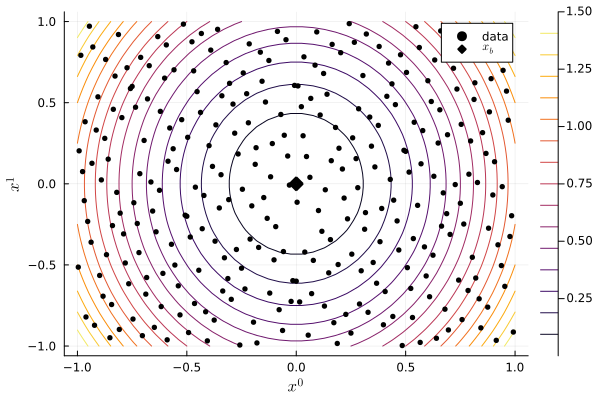

In [118]:
pDataScatter=contour(xx, yy, H_ref.(x',y),xlabel=L"x^0",ylabel=L"x^1")
scatter!(Data[1,:],Data[3,:],label="data",markersize=3,color=:black)
scatter!(basept[1:1],basept[2:2], markershape=:x, markersize=4, markerstrokewidth=12, label=L"x_b",color=:black);
#plot!(size=(300,200),right_margin=2Plots.mm,left_margin=0Plots.mm)

In [46]:
#savefig(pDataScatter,"plots/DataScatter.pdf");

#   kernel definition

In [47]:
# kernel definition
lengthscale = 1*ones(dimTQ); #[0.9; 0.9; 0.9; 0.9]

# squared exponential
kernel(a,b) = exp(-0.5*sum(((a-b)./lengthscale).^2))
kernel(q1,q1dot,q2,q2dot) = kernel([q1;q1dot],[q2;q2dot])

vol_n_ball = pi^(dimTQ/2)/gamma(dimTQ/2+1)*prod(lengthscale)
samples_per_lengthscale_ball = vol_n_ball*samples_per_unit
println("# samples within length scale: "*string(samples_per_lengthscale_ball))


# samples within length scale: 92.52754126021273


# Computation of conditional mean and covariance operator

In [49]:
println("Define conditional mean L_ml and variances "*mNow())

L_ml, var_ml_operator, var_ml_pts, var_ml_p, var_ml_H, Theta = Lagrangian_Gamblet(kernel,data_TQ2,basept; normalisation_balancing=bnd_value);
println(mNow())


Define conditional mean L_ml and variances 2024-04-28_18:01:37
2024-04-28_18:02:58


## Evaluation

### check internal errors (sanity check)

In [50]:
# check normalisation
println("Normalisation: ")
println("L_ml(basept) "*string(L_ml(basept))*", p_ml(basept) "*string(conjp(L_ml,basept)))

# check whether variance of EulerLagrange operator (interpreted as observable) is zero at data
var_ml_el = var_ml_operator.( [L-> (qjet -> el(L,qjet)[j]) for j=1:dimQ]);

max_var_ml=[maximum(abs.(var_ml_el[j].(data_TQ2))) for j=1:dimQ]
println("Max var_ml_el(L_ml,data) "*string(max_var_ml))

# conditioning of linear problem in evaluation
println("Condition linear problem in mean/cov evaluation "*string(cond(Theta)))

EL_ml,acc_ml,H_ml = EulerLagrange(L_ml);

# Test how well collocation conditions are fulfilled
collocation_test0 = EL_ml.(data_TQ2)
collocation_test = (a -> a[1]).(collocation_test0); # unpack because example is just 1d
mCollTest=maximum(abs.(collocation_test)) # max error EL

println("Max el(L_ml,data) "*string(mCollTest))

pDataScatterEvaluate = scatter(Data[1,:],Data[2,:]; zcolor=abs.(collocation_test),label="colloc pts",markersize=3)
pDataScatterColl=scatter!(basept[1:1],basept[2:2], markershape=:xcross, markersize=5, markerstrokewidth=5, label="bnd. cond",xlabel=L"x^0",ylabel=L"x^1")
plot!(size=(300,200),right_margin=4Plots.mm);

Normalisation: 
L_ml(basept) 0.9999999999998757, p_ml(basept) [1.0000000000003755, 1.0000000000001164]
Max var_ml_el(L_ml,data) [2.842170943040401e-14, 1.9539925233402755e-14]
Condition linear problem in mean/cov evaluation 4.326380955892185e8
Max el(L_ml,data) 2.298161660974074e-12


In [51]:
#savefig(pDataScatterColl,"plots/DataScatterColl_"*mNow()*".pdf")

### acceleration prediction

In [122]:
# test domain

deltaTestx = 1
deltaTesty = 1

xx = range(-deltaTestx, deltaTestx, length=40)
yy = range(-deltaTesty, deltaTesty, length=50)

x=(a->[a;0]).(xx)
x2=(a->[0;a]).(xx)
y=(a->[a;0]).(yy)
y2=(a->[0;a]).(yy);

In [ ]:
# test how well accelleration matches reference
acc_ml_val = [acc_ml(a,b) for a = x, b = y]
acc_ref_val = [acc_ref(a,b) for a = x, b = y];

# discrete norm of error, eucl. norm for acc-vector
acc_diff = acc_ref_val-acc_ml_val
diffs= norm.(acc_diff)

inf_err = maximum(diffs)
l2_err = sqrt(sum(diffs.^2)*(xx[2]-xx[1])*(yy[2]-yy[1]))
l1_err = sum(diffs)*(xx[2]-xx[1])*(yy[2]-yy[1])


println("discrete l1,l2,linf acceleration error: "*string(l1_err)*", "*string(l2_err)*", "*string(inf_err))

In [123]:
# error heat map
pAccml0=heatmap(yy, xx, log.(diffs), xlabel=L"x^0",ylabel=L"\dot{x}^0")

In [121]:
#plot!(size=(300,200),right_margin=3Plots.mm)
#savefig(pAccml0,"plots/Accml_"*mNow()*".pdf")

In [55]:
# test how well accelleration matches reference (q1/q2)
acc_ml_val = [acc_ml(a,b) for a = x, b = x2]
acc_ref_val = [acc_ref(a,b) for a = x, b = x2];

# discrete norm of error, eucl. norm for acc-vector
acc_diff = acc_ref_val-acc_ml_val
diffs= norm.(acc_diff)

inf_err = maximum(diffs)
l2_err = sqrt(sum(diffs.^2)*(xx[2]-xx[1])*(xx[2]-xx[1]))
l1_err = sum(diffs)*(xx[2]-xx[1])*(xx[2]-xx[1])


println("discrete l1,l2,linf acceleration error: "*string(l1_err)*", "*string(l2_err)*", "*string(inf_err))

discrete l1,l2,linf acceleration error: 0.10730867930909939, 0.10775477600036498, 0.7376914918953226


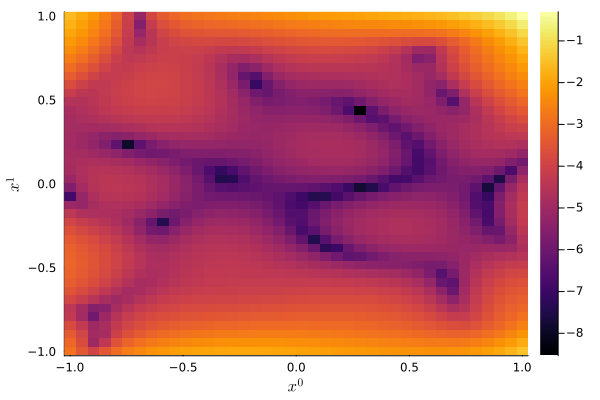

In [127]:
# error heat map
pAccml0q1q2=heatmap(xx, xx, log.(diffs), xlabel=L"x^0",ylabel=L"x^1")
#plot!(size=(300,200),right_margin=3Plots.mm)

In [57]:
#savefig(pAccml0q1q2,"plots/Accmlq1q2_"*mNow()*".pdf")

### Hamiltonian prediction

In [ ]:
# contour of Hamiltonian H(q,qdot)
H_ml_val = [H_ml(a,b) for a in x, b in y];

pcontourHml0=contour(yy, xx, H_ml_val,xlabel=L"x^0",ylabel=L"\dot{x}^0")
#plot!(size=(300,200))

In [60]:
#savefig(pcontourHml0,"plots/ContourHml0_"*mNow()*".pdf")

In [62]:
pHmlVal=plot(yy,xx,H_ml_val,st=:surface,xlabel=L"x^0",ylabel=L"\dot{x}^0",zlabel=L"H")#,camera=(-30,30))
plot!(dpi=600); plot!(size=(300,200))

In [63]:
#savefig(pHmlVal,"plots/pHmlVal_"*mNow()*".png")

In [64]:
# test consistency with boundary condition
var_ml_H(basept)

# variance of H
var_ml_H_val = [var_ml_H(a,b) for a in x, b in y];

# contour variance of H
pcontour_var_ml_H = heatmap(yy,xx,var_ml_H_val,xlabel=L"x^0",ylabel=L"\dot{x}^0")
plot!(size=(300,200))

In [65]:
#savefig(pcontour_var_ml_H,"plots/contour_var_ml_H_"*mNow()*".pdf")

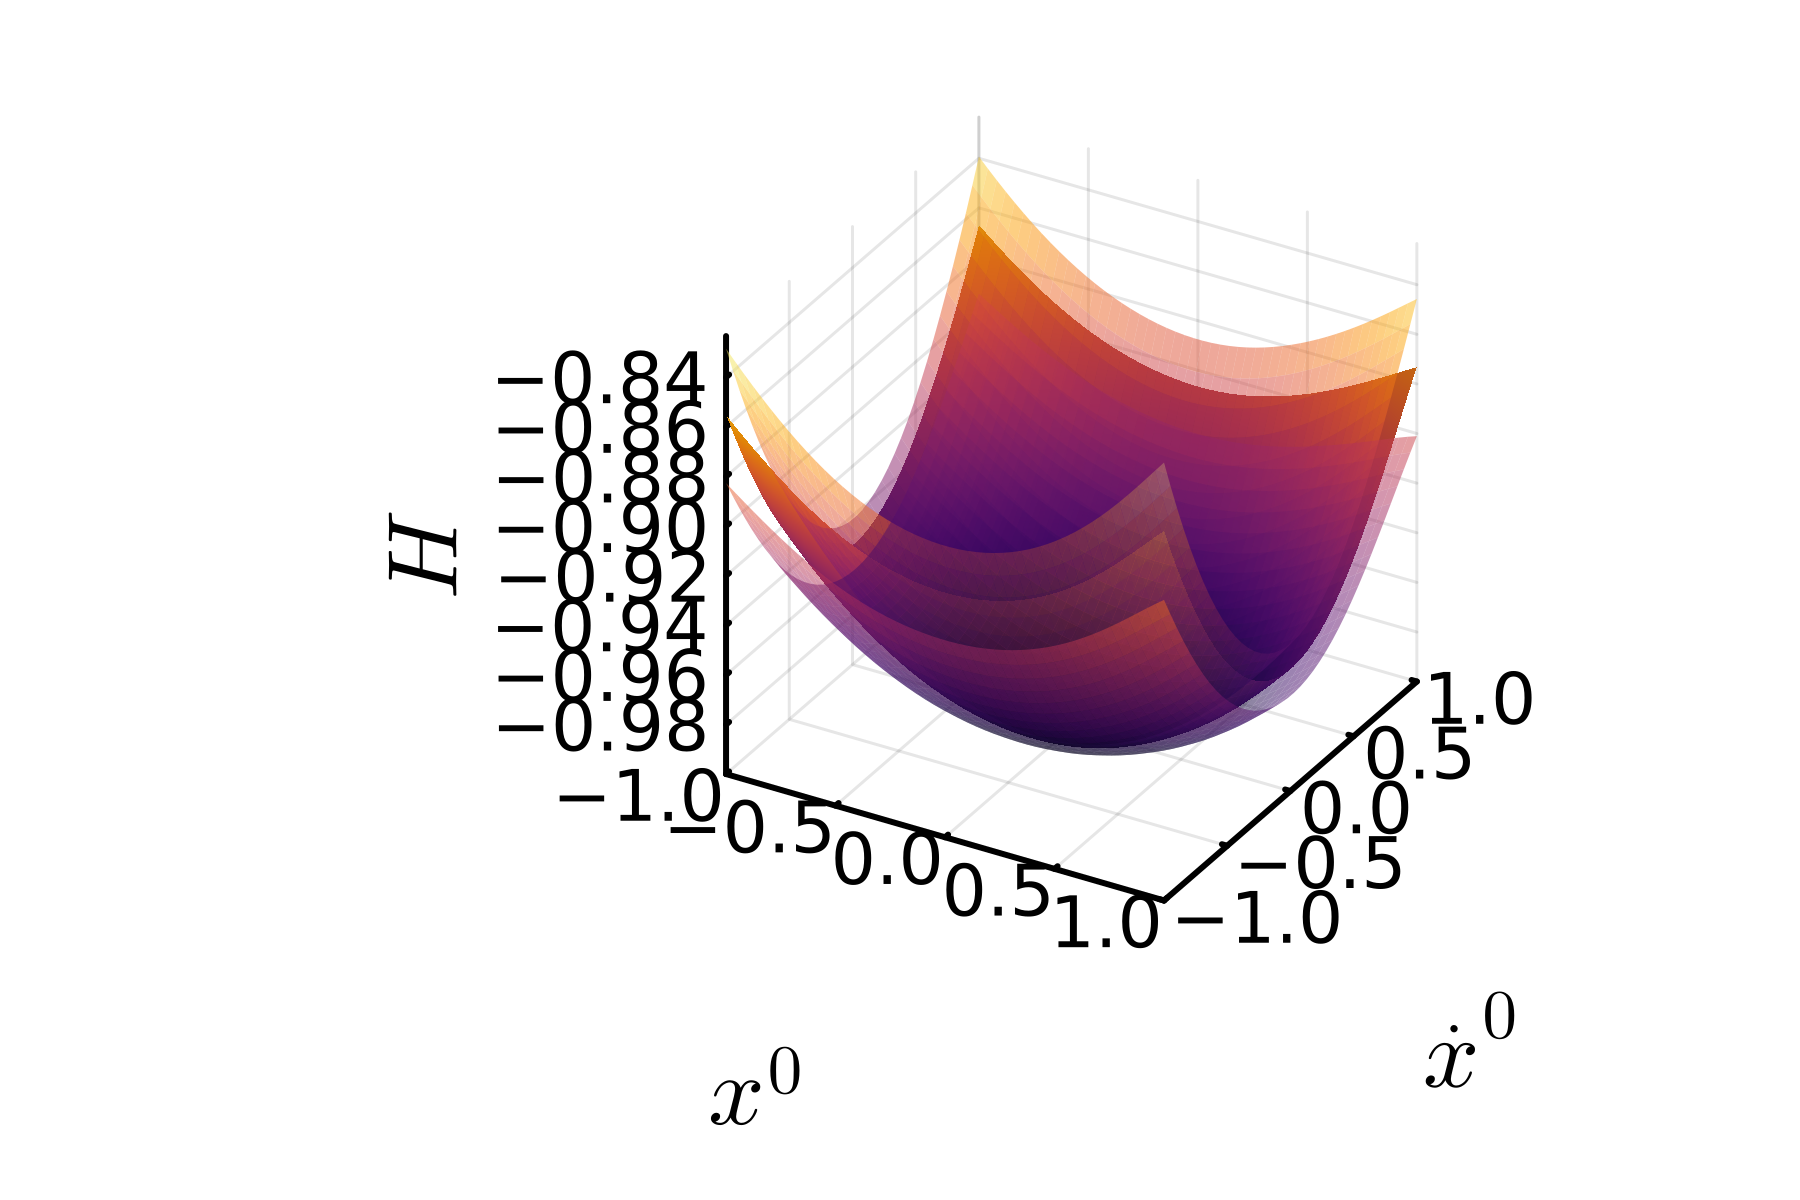

In [89]:
factor_std = 0.2
plot(yy,xx,H_ml_val,st=:surface, legend = :none)
plot!(yy,xx,H_ml_val + factor_std*(sqrt.(var_ml_H_val)),st=:surface,alpha=0.5) 
plot!(xlabel=L"x^0", ylabel=L"\dot{x}^0",zlabel=L"H")
pHamStd=plot!(yy,xx,H_ml_val - factor_std*(sqrt.(var_ml_H_val)),st=:surface,alpha=0.5)
plot!(dpi=600)
plot!(size=(300,200))

In [67]:
#savefig(pHamStd,"plots/pHamStd_"*mNow()*".png")

### variances

In [ ]:
# contour variance of L
var_ml_pts_val = [var_ml_pts(a,b) for a in x, b in y]

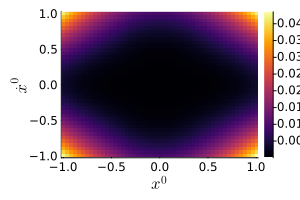

In [88]:
pcontour_var_ml_pts = heatmap(yy,xx,var_ml_pts_val,xlabel=L"x^0",ylabel=L"\dot{x}^0")
plot!(size=(300,200))

In [69]:
#savefig(pcontour_var_ml_pts,"plots/contour_var_ml_pts_"*mNow()*".pdf")

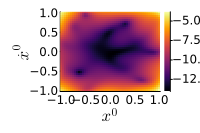

In [79]:

function var_ml_el_norm(x) 
    z = [x; acc_ml(x)]
    return norm([var_ml_el[1](z); var_ml_el[2](z)])
end

# contour variance of EL
var_ml_el_val_q1q1dot = [var_ml_el_norm([a; b]) for a in x, b in y];
pcontour_var_ml_el = heatmap(yy,xx,log.(var_ml_el_val_q1q1dot),xlabel=L"x^0",ylabel=L"\dot{x}^0")
plot!(size=(200,133),right_margin=3Plots.mm)

In [71]:
#savefig(pcontour_var_ml_el,"plots/contour_var_ml_el_q1q1dot_"*mNow()*".pdf")

In [ ]:
var_ml_el_val_q1q2 = [var_ml_el_norm([a; b]) for a in x, b in x2];

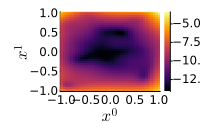

In [83]:
pcontour_var_ml_el = heatmap(xx,xx,log.(var_ml_el_val_q1q2),xlabel=L"x^0",ylabel=L"x^1")
plot!(size=(200,133),right_margin=3Plots.mm)

In [73]:
#savefig(pcontour_var_ml_el,"plots/contour_var_ml_el_q1q2_"*mNow()*".pdf")

In [90]:
# dynamics prediction from initial data of sol_ref
tspan_0 = (0.,100.)

println("Compute dynamics "*mNow())
sol1_ml = DELSolve(LdMP(L_ml,h_ref0),sol_ref[:,1],sol_ref[:,2],steps0;ftol=1e-8);

Compute dynamics 2024-04-28_18:43:35


Progress: 100%|█████████████████████████████████████████| Time: 1:03:21m39m


Plotting/Saving of results 2024-04-28_19:53:09


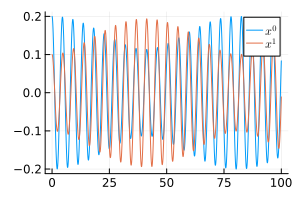

In [105]:
println("Plotting/Saving of results "*mNow())

psol1_ml=plot(tt0,sol1_ml', label=[L"x^0" L"x^1"])
plot!(size=(300,200))

In [92]:
#savefig(psol1_ml,"plots/psol1_ml_"*mNow()*".pdf")

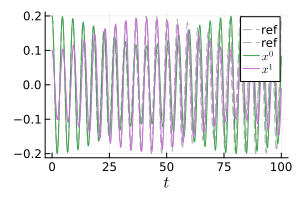

In [113]:
pcompareDyn=plot(tt0,sol_ref', label="ref",xlabel=L"t",color=:darkgray,linestyle=:dash)
plot!(tt0,sol1_ml', label=[L"x^0" L"x^1"])
plot!(size=(300,200))

In [115]:
#savefig(pcompareDyn,"plots/pcompareDyn_MP_"*mNow()*".pdf")

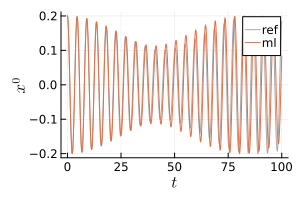

In [112]:
pcompareDynx0=plot(tt0,sol_ref[1,:], label="ref",xlabel=L"t",ylabel=L"x^0",color=:darkgray)
plot!(tt0,sol1_ml[1,:], label="ml")
plot!(size=(300,200))

In [111]:
#savefig(pcompareDynx0,"plots/pcompareDynx0_MP_"*mNow()*".pdf")

In [117]:
# save ode solution / energy / variance
#save("OdeSolution_MP_"*mNow()*".jld2","sol_ref",sol_ref,"sol1_ml",sol1_ml)

In [ ]:
#using NBInclude
#nbexport("L_Learning_CertifiedGP_MidpointRule.jl", "L_Learning_CertifiedGP_MidpointRule.ipynb")